# Look for Bad Data in Training Set

This notebook is specifically looking for bad data in the training set. Models are not training as well as expected and the prime suspect is the data quality. 
Let's dig in and see what we can find in the dataset. 

In [1]:
import numpy as np
import os
import keract
from matplotlib import pyplot as plt
import datetime

In [2]:
DATABASE_LOCATION = 'E:/cattle_data'
INPUT_PATH = DATABASE_LOCATION+'/training'
DATASET = 'training.json'

In [3]:
# load dataset (singles)
import json
import pandas as pd
with open(os.path.join(INPUT_PATH, DATASET), 'r') as file:
        frame = json.load(file)
df = pd.DataFrame(frame)
df.timestamp = pd.to_datetime(df['timestamp'], unit='ms')
print(len(df))
df.head()

120770


,weight,lot_num,prediction,auction,timestamp,path
0,565.0,3,"[{'Label': 'cow', 'Prob': '0.10884704', 'Box':...",rimbey,2021-11-30 09:07:05.958,E:/cattle_data/training/singles/rimbey_3_12644...
1,565.0,3,"[{'Label': 'cow', 'Prob': '0.14765938', 'Box':...",rimbey,2021-11-30 09:07:06.978,E:/cattle_data/training/singles/rimbey_3_12644...
2,565.0,3,"[{'Label': 'cow', 'Prob': '0.81416804', 'Box':...",rimbey,2021-11-30 09:07:07.990,E:/cattle_data/training/singles/rimbey_3_12644...
3,565.0,3,"[{'Label': 'cow', 'Prob': '0.85627973', 'Box':...",rimbey,2021-11-30 09:07:08.981,E:/cattle_data/training/singles/rimbey_3_12644...
4,565.0,3,[],rimbey,2021-11-30 09:07:09.986,E:/cattle_data/training/singles/rimbey_3_12645...


In [5]:
# drop data with no image
def has_image(path):
    return os.path.exists(path)

df = df[df.path.apply(has_image)]

Up till now we have just loaded the data as if we were training a model with it. Let's take this form of the data and see what we can find. 

## Stats and Counting

### Removing Multiple Cows

The images that we are using in this dataset are pictures from an auction lot of single cows. From some of the tests on models, it looks like there are auction lots with multiple cows in the image. 

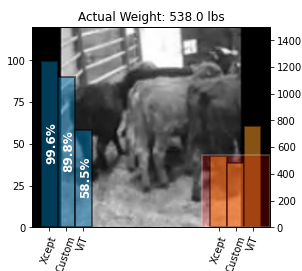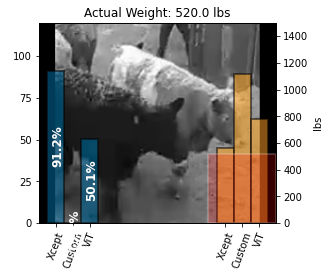

There are three hypotheses why these images are making their way into the training data. 
1. Sometimes lots with many cows are sold in batches out of the ring. If one cow is left in the ring and sold separately, the info for that cow would be taken along with the pictures for the whole lot with all the cows back to the start of that group. This happens since there is no gap between the lots where no cows are in view.
2. The cleaning algorithm was unable to separate the lots correctly
3. Lots are incorrectly labeled at the time of capture.

If indeed we are getting entire lots of incorrect data and these lots are muticow lots, then the problem of bad data is compounded by the fact that multi-cow lots are in the auction ring much longer than single cow lots. This means we are collecting data for a longer period of time on lots that we don't want than lots that we do want. 
We can visualize this by looking at the number of images per lot. 

First, we need to make a unique lot identifier. </br>
We can use the `auction` name and the `lot_num` to identify unique lots and count the number of datapoints per lot:

In [14]:
counts = df.groupby(by=['auction','lot_num']).count()
counts

weight  prediction  timestamp  path  lot
auction     lot_num                                          
beaverlodge 3            29          29         29    29   29
            4             1           1          1     1    1
            5             3           3          3     3    3
            6             1           1          1     1    1
            7             7           7          7     7    7
...                     ...         ...        ...   ...  ...
westlock    6837         33          33         33    33   33
            6838          8           8          8     8    8
            6839          7           7          7     7    7
            6840        127         127        127   127  127
            6841         19          19         19    19   19

[5841 rows x 5 columns]

Let's picture this in a graph:

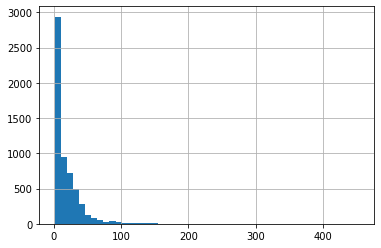

In [20]:
counts.weight.hist(bins=50);

Let's look at the stats:

In [17]:
counts.describe()

,weight,prediction,timestamp,path,lot
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,18.750214,18.750214,18.750214,18.750214,18.750214
std,25.873555,25.873555,25.873555,25.873555,25.873555
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000
75%,25.000000,25.000000,25.000000,25.000000,25.000000
max,454.000000,454.000000,454.000000,454.000000,454.000000


The majority of the lots have less than 25 images, but the max is 454!</br> 
We have a small number of lots with a lot of images. This could be the multi-cow data we want to filter out.</br>
We can look at some of the lots with high counts to see if they have multiple cows.

In [219]:
sample = counts[counts.weight > 100]
sample

weight  prediction  timestamp  path  lot
auction      lot_num                                          
beaverlodge  273         129         129        129   129  129
             453         162         162        162   162  162
             1287        135         135        135   135  135
dawson_creek 149         101         101        101   101  101
             583         113         113        113   113  113
...                      ...         ...        ...   ...  ...
westlock     6164        124         124        124   124  124
             6372        125         125        125   125  125
             6658        126         126        126   126  126
             6735        133         133        133   133  133
             6840        127         127        127   127  127

[102 rows x 5 columns]

By observing these images, we will be able to tell if there are many cows in the lot or if it was a single cow in the ring for an extended time. 
By also looking at the last images in the lot, we can see if it is case 1. where many cows are in the lot at the beginning but only one cow left at the end. 

In [ ]:
from cv2 import cv2
auction = 'westlock'
lot = 6658

h_img = 3
width = 3

sample = df[(df.auction == auction) & (df.lot_num == lot)].sample(n=width * width)
tail = df[(df.auction == auction) & (df.lot_num == lot)].tail(10)

images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in sample.path.values]

fig, ax = plt.subplots(h_img, width, figsize=(12,12))

for i in range(h_img):
    for j in range(width):
        ax[i,j].imshow(images[i*h_img + j])
        
fig.suptitle(f'Images from {auction} lot {lot}', fontsize=30, verticalalignment='top');

tail_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in tail.path.values]

fig2, ax2 = plt.subplots(h_img, width, figsize=(12,12))

for i in range(h_img):
    for j in range(width):
        ax2[i,j].imshow(tail_images[-(i*h_img + j)])
        
fig2.suptitle(f'Tail Images from {auction} lot {lot}', fontsize=30, verticalalignment='top');

There are three lots with over 300 images, let's start by analyzing these.

Lot #888 is a definate culprit of error! There are many bad images of cows jammed together. 

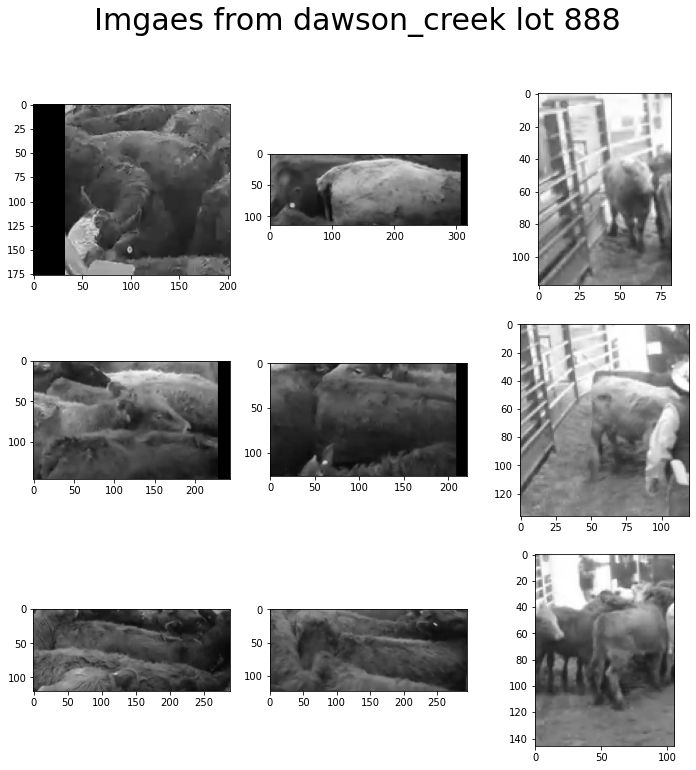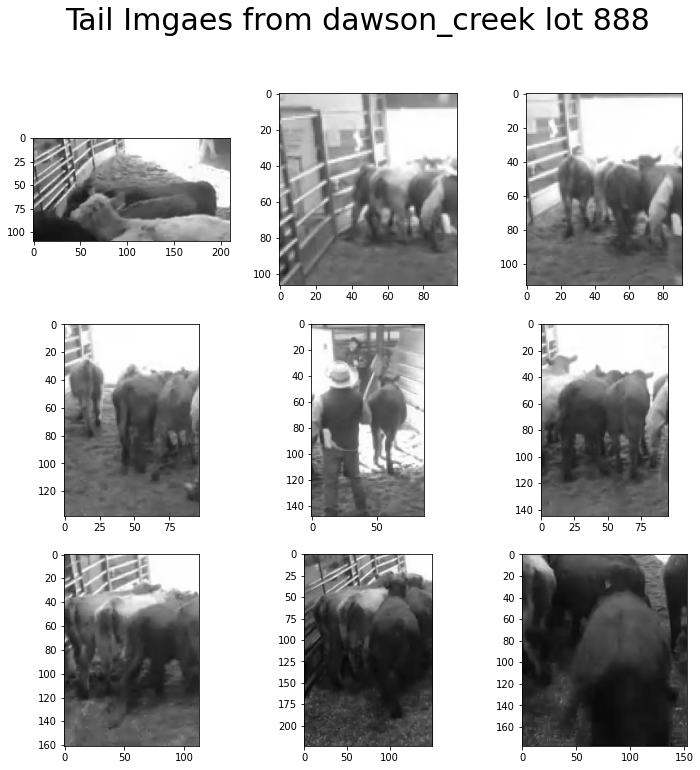

The other two lots are bulls. These bulls will be in the auction ring for a long time since they are high priced and the auctioneer wants the potential buyers to have enough time to observe them thouroughly. These last two cases, we may not want to filter out since bulls are sold less often so we want more data collected for them. The fact that there are two bulls in the ring means the weight might not be exact since the weight of one will be applied for both, but it is still a close approximation. 

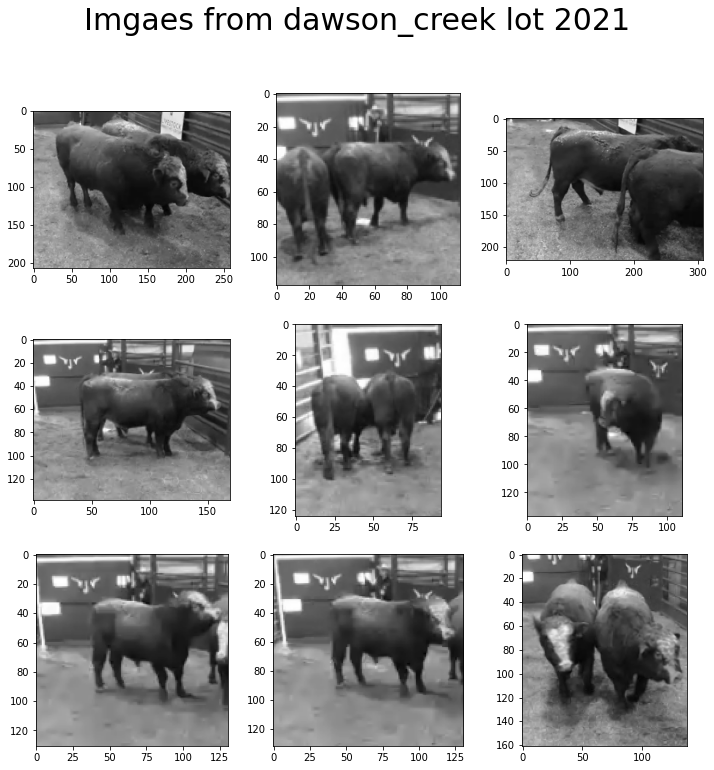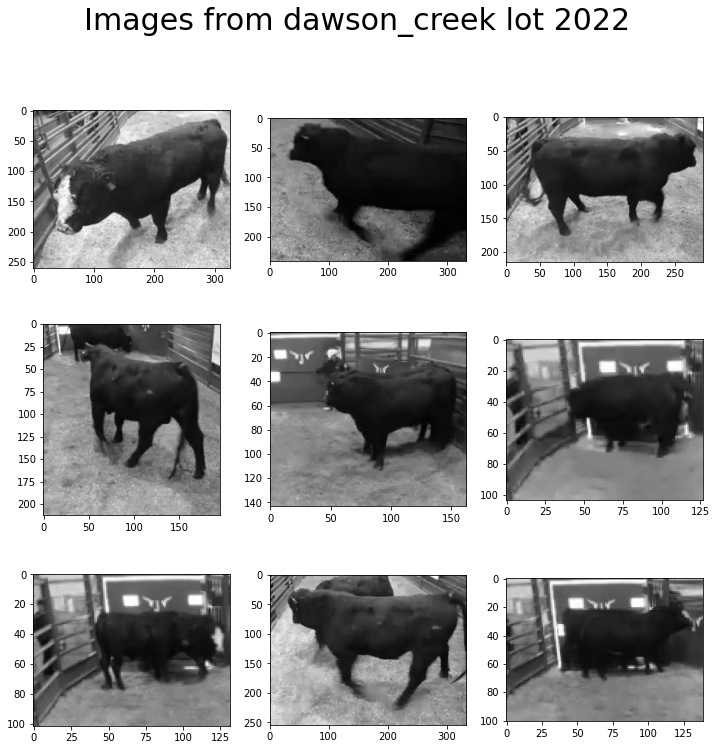

Many of the lots look like this:

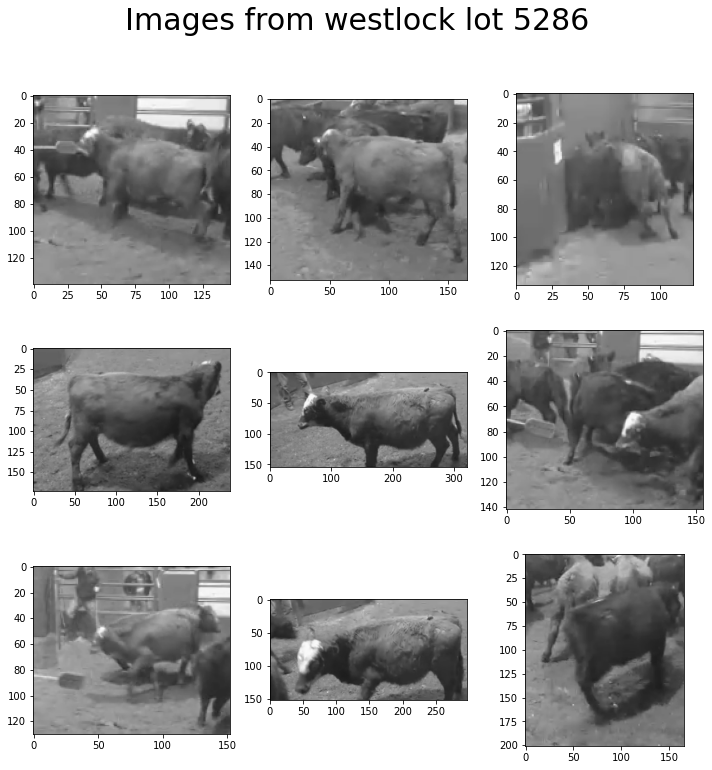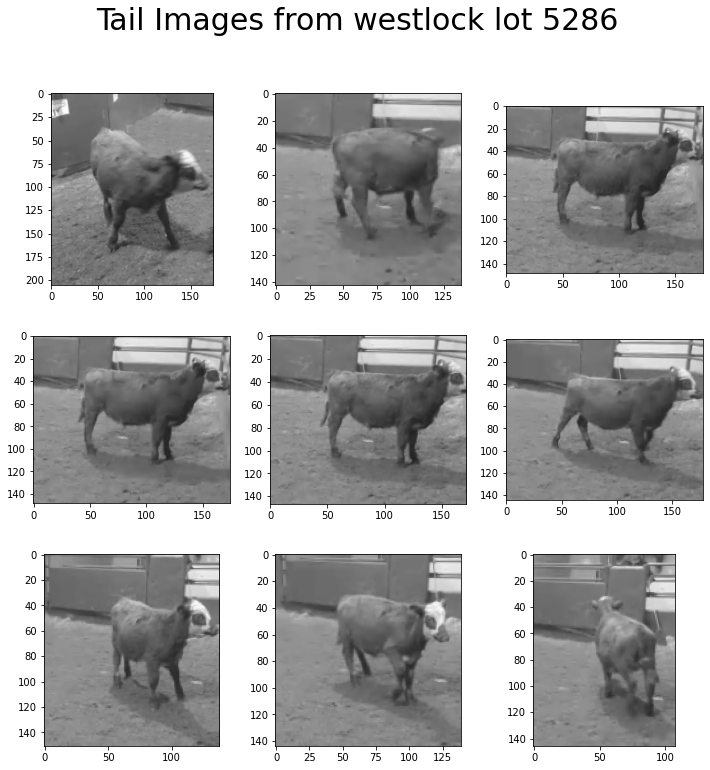

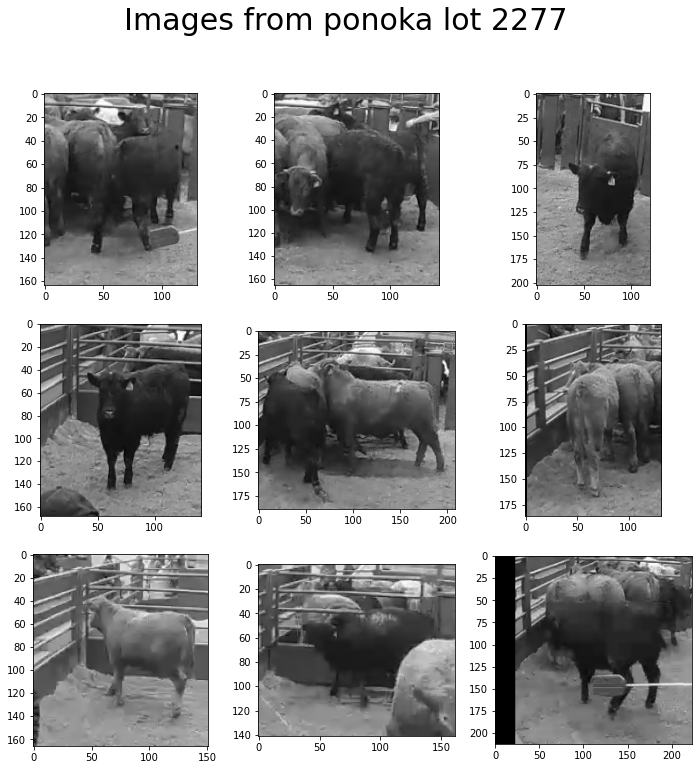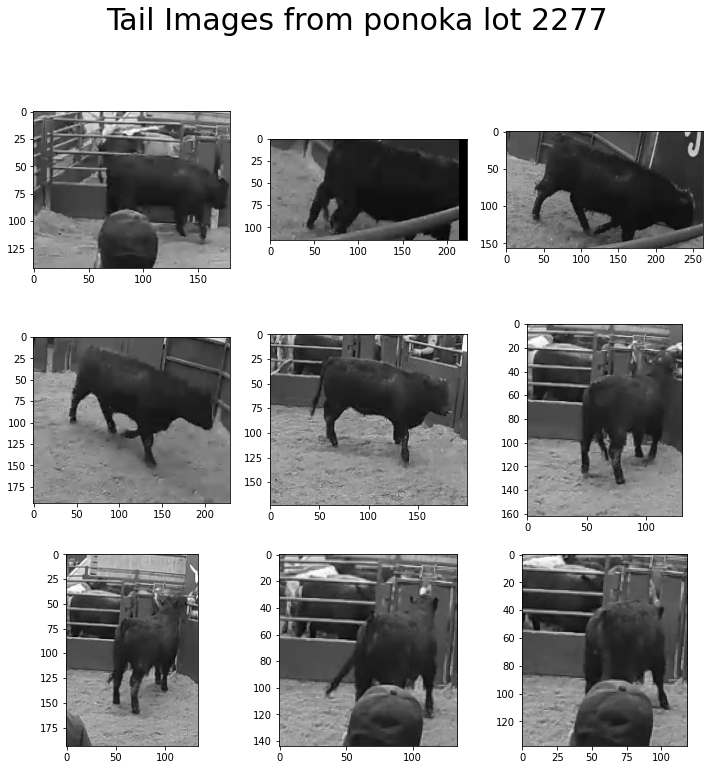

There are multiple cows if we take a random sample of the lot, but the tail has only single cows. This means after selling the bunch, they kept one cow in the ring to sell separately and my filtering algorithm applied the single cow information to the entire lot. 

## Summary of Findings

Rather than showing example images from every lot, I will summarize the results in the following table.
These are the stats for the 102 lots that have over 100 images. 


In [229]:
results = pd.read_csv('LookForBadDataResults.csv')

In [243]:
results.groupby(by=['findings']).weight.describe()

,count,mean,std,min,25%,50%,75%,max
findings,,,,,,,,
3 cows,1.0,148.0,NaN,148.0,148.0,148.0,148.0,148.0
bulls,3.0,303.0,110.258786,179.0,259.5,340.0,365.0,390.0
muti,1.0,454.0,NaN,454.0,454.0,454.0,454.0,454.0
sing_tail,1.0,118.0,NaN,118.0,118.0,118.0,118.0,118.0
single,7.0,127.0,18.903263,101.0,119.0,129.0,129.5,162.0
single_tail,85.0,143.4,42.539394,101.0,114.0,132.0,154.0,273.0
two_cows,2.0,110.0,5.656854,106.0,108.0,110.0,112.0,114.0


The vast majority of the lots with a high image count have multiple cows at the beginning and a signle cow at the end. 
- Bull sales are a reason for a single lot to be in the ring for a long time, but they are few (3%)
- Only a single instance of a complete error of multi-cow data getting into the single cow data
- 2% was due to 2 cow lots getting into single cow data
- 92% of the data errors in this set were due to hypotheses #1

Below is an example of where the problem persists in the original data cleaning:

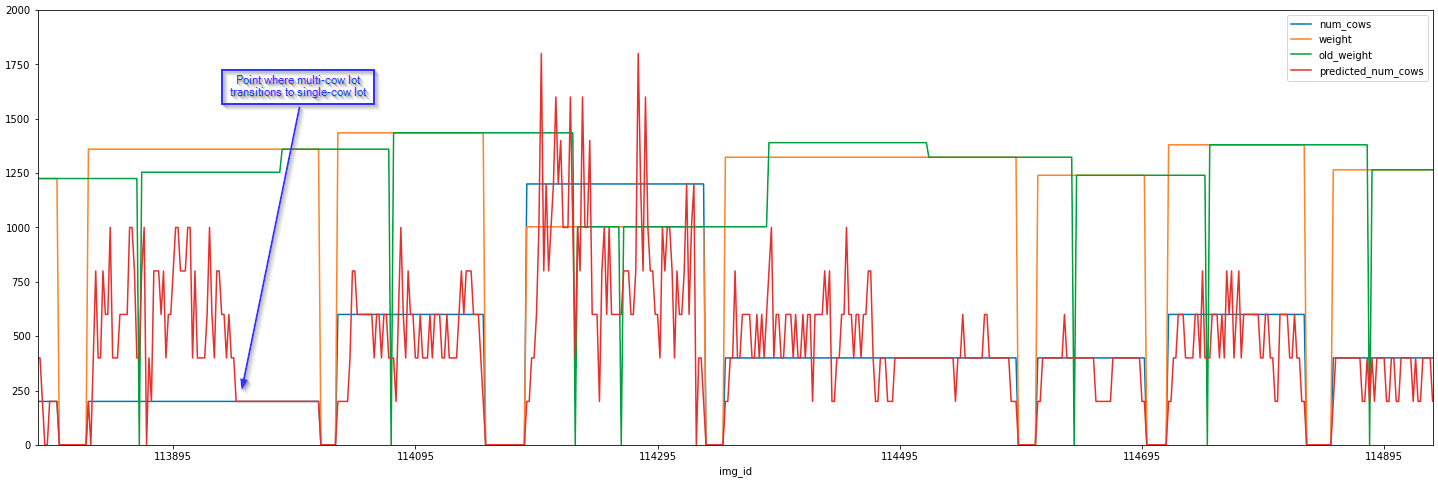

## Conclusion

There is a lot of bad data added to the training set by lots that started as multi-cow lots but ended as a single cow lot. These lots are in the ring for a considerable time and therfore contribute significantly to the dataset. Orginally, when I was observing the collection process, I noticed this process of selling one cow at the end of a multi-cow lot. At the time, it seemed like a only a negligable amount of multi-cow images would make it into the dataset because of this. 
After observe the statistics post-collection, I conclude that this source of bad-data is not insignificant and a filter needs to be applied. 

A filter could be to lots with more than 200 images as long as they are not bull sales, but the better approach would be to filter the single cows off the end of the lots during the initial data cleaning phase. 

## The Fix
A filter was added to the cleaning algorithm so the lots with transitions from multi-cow images to single-cow images are truncated to retain only the single cow data. 

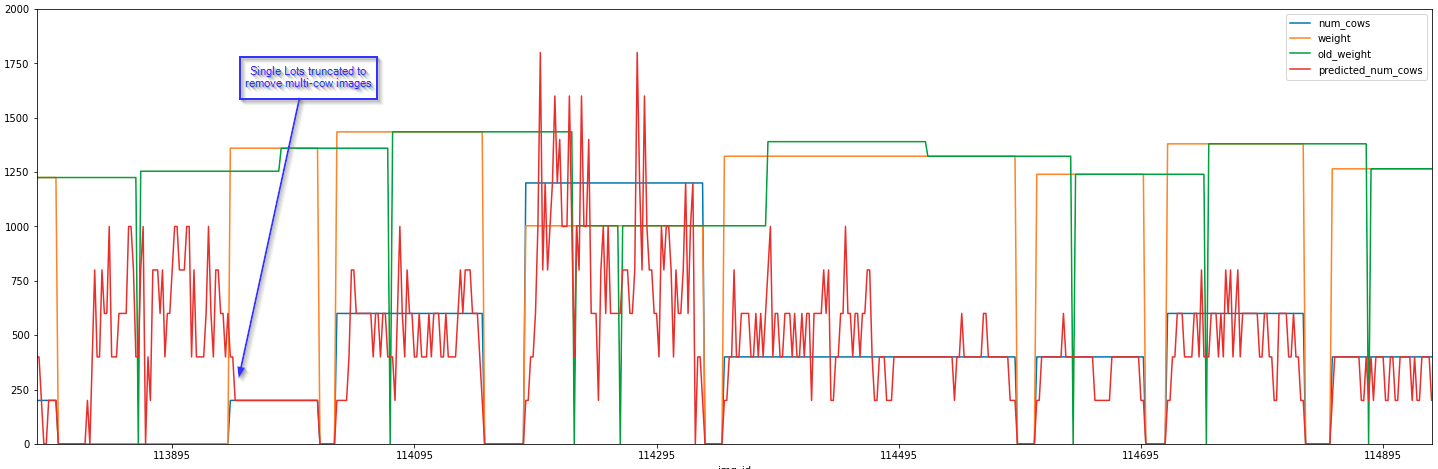

After applying the filter, the training set consisted of 15.8% of the raw data instead of 18.3% of the raw data that was used previously. 

This means that **13.7%** of the training data was bad data that was removed with this filter.